# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 6. Нейросети в обработке текста

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере [dataset](https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech)

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
%%capture
!pip install stop-words pymorphy2

In [2]:
import numpy as np 
import pandas as pd
import os
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from tqdm import tqdm 
tqdm.pandas()

from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
%%capture
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist

In [4]:
torch.manual_seed(18)

In [5]:
morpher = MorphAnalyzer()
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("no\s", "no", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [6]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
train.shape

(31962, 3)

In [10]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
X = train.drop('label', axis = 1)
y = train['label']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=13)

In [13]:
max_words = 2000
max_len = 20
num_classes = 1

# Training
epochs = 15
batch_size = 512
print_batch_n = 100

In [14]:
sw = set(get_stop_words("english"))
puncts = set(punctuation)

In [15]:
%%capture
tqdm.pandas()
X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_val['tweet'] = X_val['tweet'].progress_apply(preprocess_text)

In [16]:
train_corpus = " ".join(X_train['tweet'])
train_corpus = train_corpus.lower()

In [17]:
tokens = word_tokenize(train_corpus)

In [18]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [19]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [20]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
len(vocabulary)

1999

In [21]:
%%time
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
X_val = np.asarray([text_to_sequence(text, max_len) for text in X_val['tweet']])

CPU times: total: 3.17 s
Wall time: 3.19 s


In [22]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [23]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
train_dataset = DataWrapper(X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_val, y_val.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [25]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [27]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/15]. Step [57/57]. Loss: 0.243. Acc: 0.918. Test loss: 0.205. Test acc: 0.942
Epoch [2/15]. Step [57/57]. Loss: 0.096. Acc: 0.954. Test loss: 0.204. Test acc: 0.953
Epoch [3/15]. Step [57/57]. Loss: 0.138. Acc: 0.966. Test loss: 0.123. Test acc: 0.948
Epoch [4/15]. Step [57/57]. Loss: 0.038. Acc: 0.976. Test loss: 0.002. Test acc: 0.951
Epoch [5/15]. Step [57/57]. Loss: 0.023. Acc: 0.982. Test loss: 0.000. Test acc: 0.953
Epoch [6/15]. Step [57/57]. Loss: 0.048. Acc: 0.987. Test loss: 0.006. Test acc: 0.952
Epoch [7/15]. Step [57/57]. Loss: 0.085. Acc: 0.991. Test loss: 0.000. Test acc: 0.949
Epoch [8/15]. Step [57/57]. Loss: 0.001. Acc: 0.994. Test loss: 0.000. Test acc: 0.954
Epoch [9/15]. Step [57/57]. Loss: 0.002. Acc: 0.994. Test loss: 0.000. Test acc: 0.951
Epoch [10/15]. Step [57/57]. Loss: 0.019. Acc: 0.993. Test loss: 0.013. Test acc: 0.940
Epoch [11/15]. Step [57/57]. Loss: 0.020. Acc: 0.992. Test loss: 0.004. Test acc: 0.950
Epoch [12/15]. Step [57/57]. Loss: 0.010.

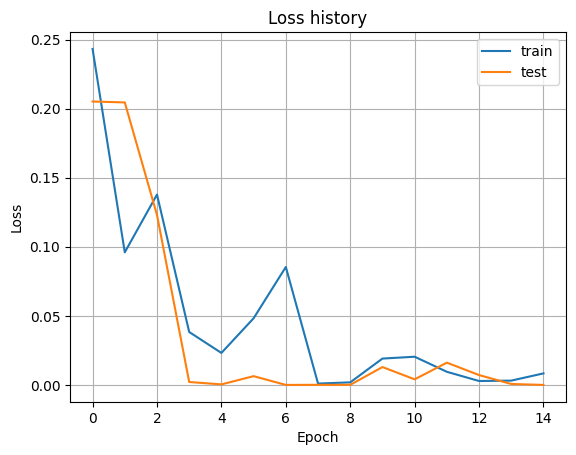

In [28]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();